# Introduction

This notebook builds up ModelPipeline class to be added to mlops_class. The purpose of this object is
* The trained ModelPipeline should be sufficient for model consumption. That is, the end user should be able to use it for prediction and explanation
* Therefore, the trained ModelPipeline can be used for model registry (backlog: consider incorprating with `mlflow` standard format). Benefit includes
    * customized functionality (e.g., case explnanation with original rather than transformed feature values, ability to bin features, etc)
    * easily experimenting with and switching algorithm, as it is wrapped under the class
* To keep the registered ModelPipeline light and essential, there is another class that is used to optimize model config.  

In [1]:
import pandas as pd
import numpy as np
from mlops_class import CustomTransformer, MLUtils
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import shap
import random

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

## Creating a Pipeline
 
We can create a ModelPipeline that preprocess the data first, and then make prediction, and maybe even offer model explanations. 

In [2]:
class ModelPipeline(BaseEstimator):

    def __init__(self, custom_transformer_params, estimator=None):
        self.custom_transformer = CustomTransformer(**custom_transformer_params)
        self.estimator = estimator
    
    def fit(self, X, y=None):
        X_train_transformed = self.custom_transformer.fit_transform(X, y)
        self.estimator.fit(X_train_transformed, y)
    
    def predict_proba(self,X):
        X_new_transformed = self.custom_transformer.transform(X)
        return self.estimator.predict_proba(X_new_transformed)
        
    def explain_model(self,X):
        X_transformed = self.custom_transformer.transform(X.copy())
        self.X_explain = X_transformed.copy()
        # get the original values for binned and numeric features to show when explaining cases
        self.X_explain[self.custom_transformer.bin_features + self.custom_transformer.num_features] = X[self.custom_transformer.bin_features + self.custom_transformer.num_features]
        self.X_explain.reset_index(drop=True)
        explainer = shap.Explainer(self.estimator)
        self.shap_values = explainer(X_transformed)  
        try:
            self.shap_values.values.shape[2] 
            self.both_class = True
        except:
            self.both_class = False
        if self.both_class:
            shap.summary_plot(self.shap_values[:,:,1])
        elif self.both_class == False:
            shap.summary_plot(self.shap_values)
    
    def explain_case(self,n):
        if self.shap_values is None:
            print("pls explain model first")
        else:
            self.shap_values.data = self.X_explain
            if self.both_class:
                shap.plots.waterfall(self.shap_values[:,:,1][n-1])
            elif self.both_class == False:
                shap.plots.waterfall(self.shap_values[n-1])

## Data for testing

In [3]:
n_feature = 10
n_inform = 6 
n_redundant = 0
n_samples = 1000
# you could choose to bin some of the features using optimal binning, the default setting is no binning
n_bin = 0 
bin_features = []

X, y = make_classification(n_samples = n_samples, n_features = n_feature, 
                            n_informative = n_inform, n_redundant=n_redundant, shuffle=False)
informative_features_names = [f'inf_{i+1}' for i in range(n_inform)]
random_features_names = [f'rand_{i+n_inform+1}' for i in range(n_feature - n_inform)]
X = pd.DataFrame(X, columns = informative_features_names + random_features_names)
# get categorical features
quantiles1 = [0, 1/4, 3/5, 1]
X['inf_1'] = pd.qcut(X['inf_1'], q=quantiles1, labels=['apple', 'pear', 'orange'])
quantiles2 = [0, 1/3, 1/2, 1]
X[f'rand_{n_inform+1}'] = pd.qcut(X[f'rand_{n_inform+1}'], q=quantiles2, labels=['cat', 'koala', 'dog'])

cat_features = X.select_dtypes(exclude='number').columns.tolist()
num_features = X.select_dtypes(include='number').columns.tolist()
group = [random.choice([0, 1]) for _ in range(n_samples)]


## Quick EDA

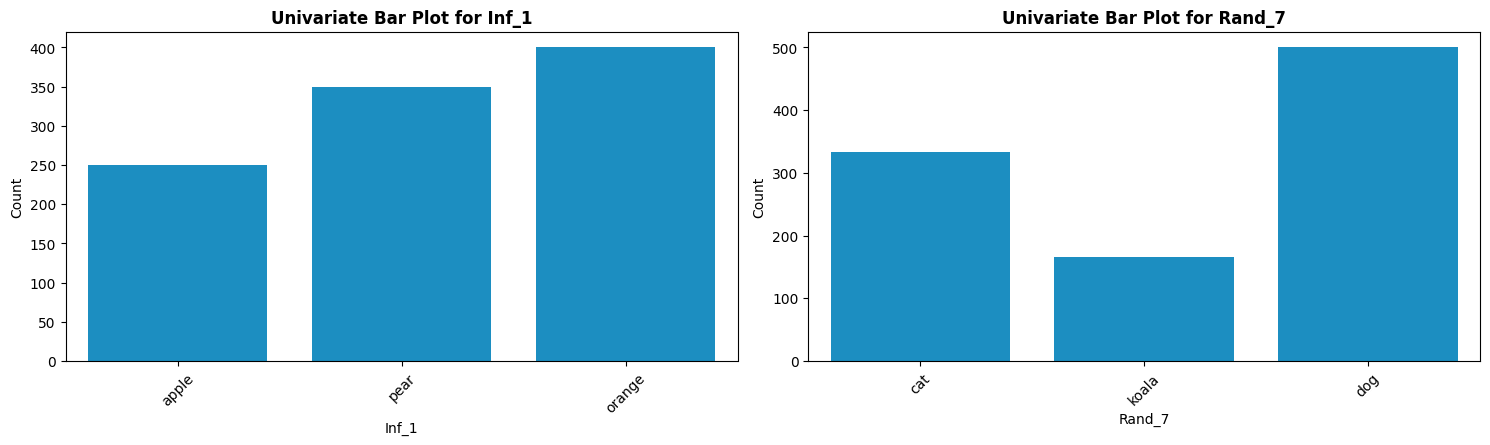

In [4]:
MLUtils.plot_cat_variables(X, cat_features,num_plots_per_row=2)

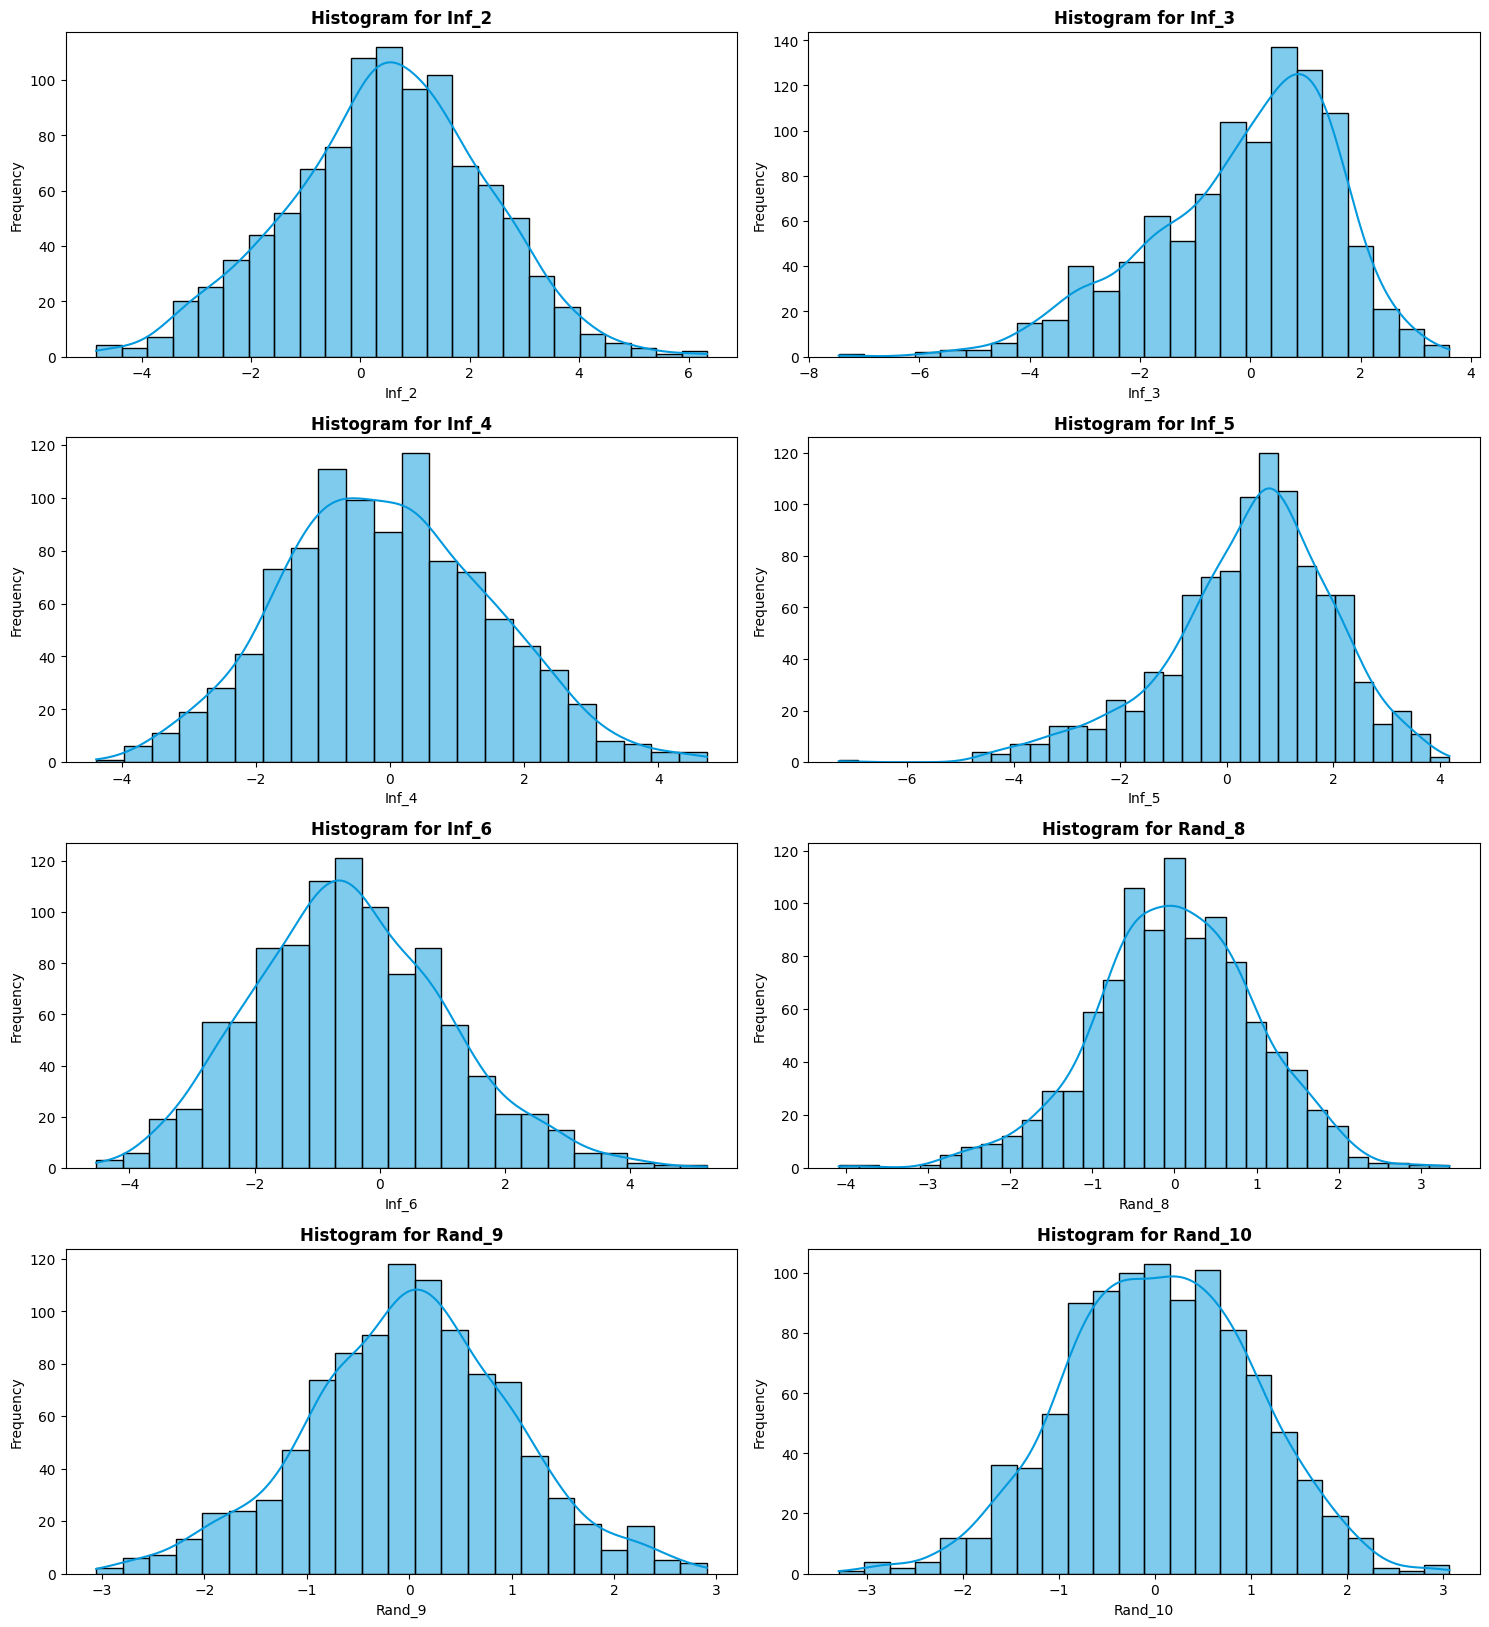

In [5]:
MLUtils.plot_num_variables(X, num_features, num_plots_per_row=2)

## Building the Model Pipeline

In [6]:
# the default setting is no binning
custom_transformer_params={
    'num_features': num_features,
    'cat_features': cat_features
}
model_pipeline = ModelPipeline(
    custom_transformer_params,
    # any modelling algorithm with sklearn API should work:
    estimator = xgb.XGBClassifier()
    # model = RandomForestClassifier()
    # model = lgb.LGBMClassifier(verbose=-1)
)

In [7]:
X_train, X_test, y_train, y_test = MLUtils.group_train_test_split(X,y,group,random_state=55)
model_pipeline.fit(X_train,y_train)
y_prob = model_pipeline.predict_proba(X_test)
roc_auc_score(y_test, y_prob[:,1])

threshold = 0.5
y_pred = np.where(y_prob[:,1]>threshold, 1, 0)

## Model Interpretation & Explanation

### Model Interpretation

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


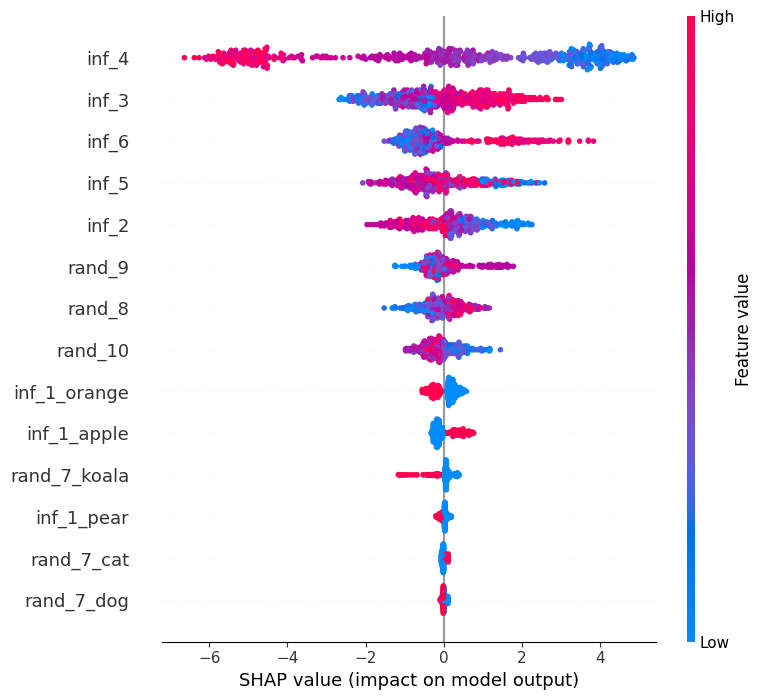

In [8]:
model_pipeline.explain_model(X_test)

### Case Interpretation

In [9]:
TP = set(np.nonzero(y_test)[0]) & set(np.nonzero(y_pred)[0])
print(TP)

{512, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 534, 535, 536, 538, 539, 540, 542, 544, 137, 138, 139, 140, 141, 143, 145, 146, 147, 148, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 248, 249, 251, 252, 253, 254, 255, 256, 257, 258, 260, 261, 262, 265, 266, 267, 269, 270, 271, 272, 273, 274, 276, 414, 415, 416, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 433, 434, 435, 437, 438, 439, 441, 443, 444, 448, 450, 452, 453, 454, 455, 456, 457, 458, 459, 461, 462, 463, 464, 465, 466, 469, 470, 471, 472, 473, 476, 477, 478, 479, 480, 481,

In [10]:
case_n = 136

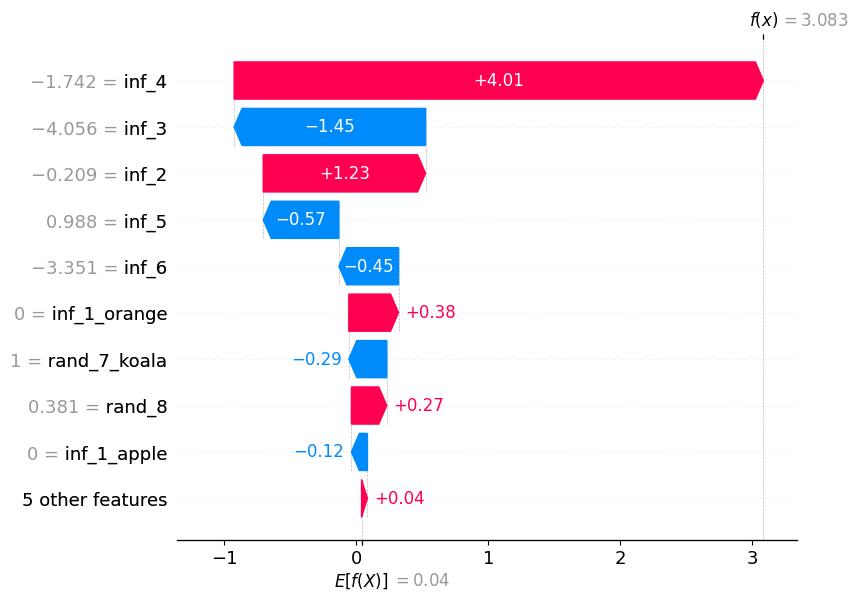

In [11]:
model_pipeline.explain_case(case_n+1)

In [12]:
# verify that the original value has been shown in the case explanation
X_test.iloc[case_n]

inf_1          pear
inf_2     -0.208561
inf_3     -4.055957
inf_4     -1.742476
inf_5      0.987543
inf_6     -3.350804
rand_7        koala
rand_8     0.380692
rand_9     1.826042
rand_10    -0.42999
Name: 247, dtype: object